In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../functions/')

from adjust_lon_xr_dataset import adjust_lon_xr_dataset
from convert_era5_to_Wm2 import convert_era5_to_Wm2

from map_plotting import southern_ocean_map
import cartopy
import cartopy.crs as ccrs


from scipy.interpolate import griddata
import gsw

In [2]:
def convert_longitude(longitude):
    if longitude < 0:
        return longitude + 360
    else:
        return longitude

#### Read and save original cyclone tracks

This only needs to happen once as it is saved as a final product that is easier to read in

In [8]:
ds_cyclones = xr.open_dataset('/home/mduplessis/data/storms/ec_centers_1981_2020.nc')

In [9]:
# read in the cyclone dataset

ds_summer = ds_cyclones.sel(TIME=ds_cyclones.TIME.dt.season=="DJF")
ds_summer = ds_summer.isel(TIME=ds_summer.LATITUDE.data < -40)

In [11]:
# read in the land sea mask from era5

lsm = xr.open_dataset('/home/mduplessis/data/era5/land_sea_mask.nc')

lsm = adjust_lon_xr_dataset(lsm).sel(latitude=slice(-40, -90))

lsm_lats = lsm.latitude.values
lsm_lons = lsm.longitude.values

In [12]:
# create lon/lat array where there is land (>0)

land_lons = []
land_lats = []

for i, lon in tqdm(enumerate(lsm_lons)):

    for j, lat in enumerate(lsm_lats):

        if lsm.sel(longitude=lon, latitude=lat).lsm > 0:

            land_lons += lon,
            land_lats += lat, 

land_lons = np.array(land_lons)
land_lats = np.array(land_lats)

1440it [01:31, 15.74it/s]


In [13]:
# remove bad lon and lats around islands - we don't want to lose too many cyclones

# south of aus & nz
idx = ((land_lons > 135) & (land_lons < 180) & (land_lats > -60) & (land_lats < -48))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# atlantic, indian
idx = ((land_lons > -62) & (land_lons < 135) & (land_lats > -63))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# west of nz
idx = ((land_lons > -180) & (land_lons < -160) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# ross sea
idx = ((land_lons > 155) & (land_lats > -68) & (land_lats < -50))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# abs
idx = ((land_lons > -135) & (land_lons < -76) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

In [14]:
# Precompute radians for land coordinates
land_lats_rad = np.radians(land_lats)
land_lons_rad = np.radians(land_lons)

# Precompute radians for cyclone coordinates
cyc_lats = ds_summer.LATITUDE.values
cyc_lons = ds_summer.LONGITUDE.values

cyc_lats_rad = np.radians(cyc_lats)
cyc_lons_rad = np.radians(cyc_lons)

In [15]:
def earth_radius(lat_radians):
    # Equatorial and polar radii in kilometers, insert latitude in radians
    a = 6378.137
    b = 6356.752
    R = np.sqrt(((a**2 * np.cos(lat_radians))**2 + (b**2 * np.sin(lat_radians))**2) / ((a * np.cos(lat_radians))**2 + (b * np.sin(lat_radians))**2))
    return R

def haversine_rad(lat1, lon1, lat2, lon2):
    R1 = earth_radius(lat1)  # insert latitude in radians
    R2 = earth_radius(lat2)  # insert latitude in radians
    R = (R1 + R2) / 2  # Average radius for the two latitudes
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [16]:
# Initialize the result array
min_dist_to_land = np.ndarray([ds_summer.TIME.size])

# Vectorized distance calculation
for i in tqdm(range(ds_summer.TIME.size)):

    cyc_lat = cyc_lats_rad[i]
    cyc_lon = cyc_lons_rad[i]    
    
    # Calculate distances to all land points at once
    distances = haversine_rad(land_lats_rad, land_lons_rad, cyc_lat, cyc_lon)
    min_dist_to_land[i] = distances.min()

100%|██████████| 849212/849212 [54:12<00:00, 261.10it/s]


In [19]:
ds_summer['min_dist_to_land'] = (('TIME'), min_dist_to_land)

In [20]:
ds_summer.to_netcdf('/home/mduplessis/data/storms/ec_centers_1981_2020_with_min_dist_to_land.nc')

#### Read and process cyclone tracks

In [21]:
# read in storm center data with min dist to land

ds_summer = xr.open_dataset('/home/mduplessis/data/storms/ec_centers_1981_2020_with_min_dist_to_land.nc')

In [22]:
# pick out all the cyclones that are within 500 km of land

ds_summer_ocean = ds_summer.isel(TIME=ds_summer.min_dist_to_land>500)

In [23]:
# remove cyclone before december 1981

ds_summer_ocean = ds_summer_ocean.isel(TIME=ds_summer_ocean.TIME > np.datetime64('1981-12-01T00:00:00'))

In [24]:
# storm number count before land removal of storms
print('all storms:', np.unique(ds_summer.STORM_ID).size)

# storm number count where ocean only storms
print('ocean storms:', np.unique(ds_summer_ocean.STORM_ID).size)

all storms: 14895
ocean storms: 13770


In [40]:
lons = ds_summer_ocean.LONGITUDE.values
lats = ds_summer_ocean.LATITUDE.values

valid_mask = ~np.isnan(lons) & ~np.isnan(lats)

# Apply the mask to both arrays
cleaned_lons = lons[valid_mask]
cleaned_lats = lats[valid_mask]

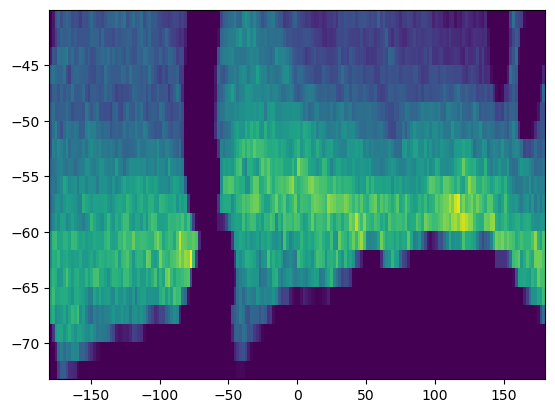

In [47]:
cyc_hist, x, y, img = plt.hist2d(cleaned_lons, cleaned_lats, bins=(180, 20))

In [69]:
# Create a custom colormap (assuming cmo is cmocean.cm)
cmap = plt.colormaps.get_cmap('PuBu')
if hasattr(cmap, 'set_under'):
    cmap.set_under('white')

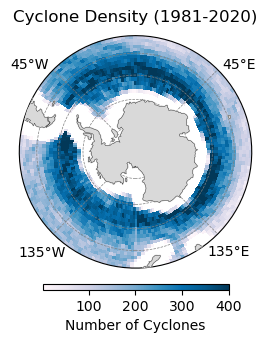

In [ ]:
# plot all the cyclones that are minimum distance of 500 km away from land

fig, ax = plt.subplots(figsize=(3, 4), subplot_kw={'projection': ccrs.Orthographic(0, -90)})

ax = southern_ocean_map(ax)

#ax.scatter(land_lons, land_lats, s=0.1, c='tab:blue', transform=ccrs.PlateCarree())

img = ax.pcolormesh(x[:-1], y[:-1], cyc_hist.T, transform=ccrs.PlateCarree(), cmap=cmap, vmin=1, vmax=400)

ax.set_title('Cyclone Density (1981-2020)', fontsize=12, pad=10)

plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, label='Number of Cyclones', shrink=0.8, aspect=30)

plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figures/cyclone_density_1981_2020.png', dpi=400, bbox_inches='tight')


In [74]:
len_storms = [ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==storm).TIME.size for storm in np.unique(ds_summer_ocean.STORM_ID)]

(array([4.910e+02, 7.030e+02, 7.930e+02, 7.780e+02, 1.782e+03, 1.576e+03,
        1.352e+03, 1.146e+03, 9.590e+02, 8.190e+02, 7.030e+02, 5.060e+02,
        4.210e+02, 3.550e+02, 2.850e+02, 2.260e+02, 1.910e+02, 1.530e+02,
        1.230e+02, 9.100e+01, 6.800e+01, 6.700e+01, 4.800e+01, 2.600e+01,
        2.500e+01, 2.100e+01, 1.100e+01, 7.000e+00, 1.300e+01, 9.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
        132., 138., 144., 150., 156., 162., 168., 174., 180., 186., 192.,
        198., 204., 210., 216., 222., 228., 234., 240., 246., 252., 258.]),
 <BarContainer object of 43 artists>)

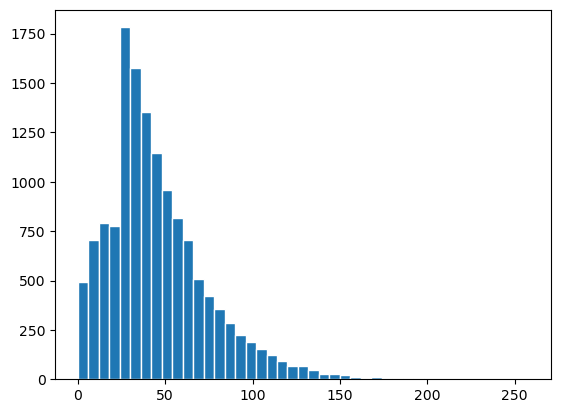

In [76]:
# plot the length of storms

plt.hist(np.array(len_storms), bins=np.arange(0, 264, 6), edgecolor='w')

In [77]:
# filter out storms that are less than 24 hours long

storm_id_24hours = np.unique(ds_summer_ocean.STORM_ID)[np.array(len_storms)<24]

filter_array = []

for unique_storm_id in tqdm(np.unique(ds_summer_ocean.STORM_ID)):
    
    if unique_storm_id in storm_id_24hours:
        filter_array.append(np.zeros(ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==unique_storm_id).TIME.size))

    else:
        filter_array.append(np.ones(ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==unique_storm_id).TIME.size))

filter_array = np.concatenate(filter_array)

ds_summer_ocean_filtered = ds_summer_ocean.isel(TIME=filter_array==1)        

  0%|          | 0/13770 [00:00<?, ?it/s]

100%|██████████| 13770/13770 [00:18<00:00, 739.72it/s]


In [78]:
# create new storm id for the filtered dataset

new_storm_id = []
counter = 0

for unique_storm_id in tqdm(np.unique(ds_summer_ocean_filtered.STORM_ID)):
     
    counter += 1

    new_storm_id.append(np.zeros(ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==unique_storm_id).TIME.size) + counter)

new_storm_id = np.concatenate(new_storm_id).astype(int)

ds_summer_ocean_filtered['STORM_ID'] = (('TIME'), new_storm_id)

100%|██████████| 11005/11005 [00:14<00:00, 757.70it/s]


In [79]:
len_storms = [ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==storm).dims['TIME'] for storm in np.unique(ds_summer_ocean_filtered.STORM_ID)]

/tmp/ipykernel_34973/730091671.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  len_storms = [ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==storm).dims['TIME'] for storm in np.unique(ds_summer_ocean_filtered.STORM_ID)]
/tmp/ipykernel_34973/730091671.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  len_storms = [ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==storm).dims['TIME'] for storm in np.unique(ds_summer_ocean_filtered.STORM_ID)]
/tmp/ipykernel_34973/730091671.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to

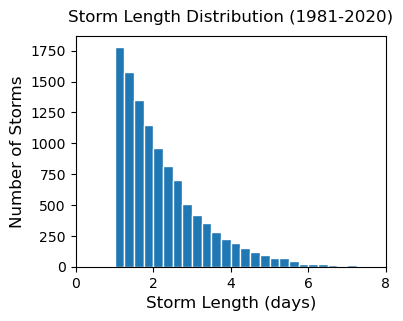

In [90]:
fig, ax = plt.subplots(figsize=(4, 3)) 

ax.hist(np.array(len_storms)/24, bins=np.arange(0, 10, 0.25), edgecolor='w')

ax.set_xlabel('Storm Length (days)', fontsize=12)
ax.set_ylabel('Number of Storms', fontsize=12)
ax.set_title('Storm Length Distribution (1981-2020)', fontsize=12, pad=10)

ax.set_xlim(0, 8)

plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figures/storm_length_distribution_1981_2020.png', dpi=400, bbox_inches='tight')

In [92]:
ds_summer_ocean_filtered.STORM_ID.attrs['description'] = 'Storm ID for cyclones that are at least 24 hours long and at least 500 km away from land'

In [94]:
ds_summer_ocean_filtered.to_netcdf('/home/mduplessis/data/storms/ec_centers_1981_2020_500km_from_land_filtered_24hours.nc')